# Calibration

In [1]:
library(ggplot2)
library(qqman)
library(gridExtra)
fig_dir="/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"
fig_size = function(sel_w, sel_h){ options(repr.plot.width = sel_w, repr.plot.height = sel_h)}



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





In [2]:
### From: https://slowkow.com/notes/ggplot2-qqplot/#:~:text=Lambda%3A%20a%20measure%20of%20inflated,are%20more%20significant%20than%20expected.
gg_qqplot <- function(ps, ci = 0.95) {
  n  <- length(ps)
  df <- data.frame(
    observed = -log10(sort(ps)),
    expected = -log10(ppoints(n)),
    clower   = -log10(qbeta(p = (1 - ci) / 2, shape1 = 1:n, shape2 = n:1)),
    cupper   = -log10(qbeta(p = (1 + ci) / 2, shape1 = 1:n, shape2 = n:1))
  )
  log10Pe <- expression(paste("Expected -log"[10], plain(P)))
  log10Po <- expression(paste("Observed -log"[10], plain(P)))
  ggplot(df) +
    geom_ribbon(
      mapping = aes(x = expected, ymin = clower, ymax = cupper),
      alpha = 0.1
    ) +
    geom_point(aes(expected, observed), shape = 20, size = 3) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)
}

inflation <- function(ps) {
  chisq <- qchisq(1 - ps, 1)
  lambda <- median(chisq) / qchisq(0.5, 1)
  lambda
}

In [3]:
mafs = read.table("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/mafs/1K1K.chr22.info_allMAFs.txt", header = FALSE)
colnames(mafs) = c('ID', 'MAF')

get_allele = function(input_str){
    return(paste(strsplit(strsplit(input_str,"_")[[1]][1], "\\:")[[1]], collapse = ":"))
}

In [4]:
# Type 1 error reporting
fpr <-function(maf_string, celltypes = c("Myeloid", "B", "T", "NK", "allcells")){
    all_res = data.frame()
    for(i in c(1:length(celltypes))){
        celltype = celltypes[i]
        res = read.delim(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,
                  "/",maf_string,"/GeNA_sumstats.txt"), header = TRUE)
        res$ID = apply(as.matrix(res$ID, ncol = 1), 1, get_allele)
        res['nom_sig'] = 1*(res$P<0.05)
        all_res = rbind(all_res, data.frame("nom_sig"= res$nom_sig, "ID"= res$ID, "k"=res$k,
                                            "P"= res$P, "celltype"= rep(celltype, nrow(res))))
    }
    print("Overall")
    print(paste0("Total tests: ",dim(all_res)[1]))
    print(paste0("Total nominally associated: ", sum(all_res$nom_sig)))
    fpr_bysnp = aggregate(all_res[,c("nom_sig")], list(all_res$ID), mean)
    colnames(fpr_bysnp) = c("ID", "FPR")
    print(sprintf("Type 1 error at ɑ = 0.05: %.3f±%.4f", mean(fpr_bysnp$FPR), sd(fpr_bysnp$FPR)))

    for(celltype in celltypes){
        print(paste0("By major cell type group: ", celltype))
        fpr_bysnp = aggregate(all_res[all_res$celltype==celltype,c("nom_sig")], 
                              list(all_res$ID[all_res$celltype==celltype]), mean)
        colnames(fpr_bysnp) = c("ID", "FPR")
        print(sprintf("Type 1 error at ɑ = 0.05: %.3f±%.4f", mean(fpr_bysnp$FPR), sd(fpr_bysnp$FPR)))
    }
}

In [5]:
fpr(maf_string = "contMAF") 

[1] "Overall"
[1] "Total tests: 400000"
[1] "Total nominally associated: 18465"
[1] "Type 1 error at ɑ = 0.05: 0.046±0.0063"
[1] "By major cell type group: Myeloid"
[1] "Type 1 error at ɑ = 0.05: 0.046±0.0138"
[1] "By major cell type group: B"
[1] "Type 1 error at ɑ = 0.05: 0.047±0.0145"
[1] "By major cell type group: T"
[1] "Type 1 error at ɑ = 0.05: 0.047±0.0147"
[1] "By major cell type group: NK"
[1] "Type 1 error at ɑ = 0.05: 0.046±0.0147"
[1] "By major cell type group: allcells"
[1] "Type 1 error at ɑ = 0.05: 0.046±0.0142"


In [6]:
fpr(maf_string = "MAF5") 

[1] "Overall"
[1] "Total tests: 400000"
[1] "Total nominally associated: 19219"
[1] "Type 1 error at ɑ = 0.05: 0.048±0.0067"
[1] "By major cell type group: Myeloid"
[1] "Type 1 error at ɑ = 0.05: 0.049±0.0151"
[1] "By major cell type group: B"
[1] "Type 1 error at ɑ = 0.05: 0.048±0.0151"
[1] "By major cell type group: T"
[1] "Type 1 error at ɑ = 0.05: 0.046±0.0137"
[1] "By major cell type group: NK"
[1] "Type 1 error at ɑ = 0.05: 0.048±0.0143"
[1] "By major cell type group: allcells"
[1] "Type 1 error at ɑ = 0.05: 0.048±0.0156"


In [7]:
plot_QQ <-function(files, title){
    all_res = data.frame()
    for(res_file in files){
        res = read.delim(res_file, header = TRUE)
        res$ID = apply(as.matrix(res$ID, ncol = 1), 1, get_allele)
        res['nom_sig'] = 1*(res$P<0.05)
        all_res = rbind(all_res, data.frame("nom_sig"= res$nom_sig, "ID"= res$ID, "P"= res$P))
    }
    fpr_bysnp = aggregate(all_res[,c("nom_sig")], list(all_res$ID), mean)
    colnames(fpr_bysnp) = c("ID", "FPR")
    ps = all_res$P
    return(gg_qqplot(ps) + theme_bw(base_size = 24) + 
        annotate(geom = "text", x = -Inf, y = Inf, hjust = -0.15, vjust = 3 + 0.15 * 3, 
            label = sprintf("\U03BB = %.2f", inflation(ps)), size = 7) +
        annotate(geom = "text", x = -Inf, y = Inf, hjust = -0.03, vjust = 1 + 0.15 * 3, 
            label = sprintf("Type 1 error at \U1D6FC = 0.05: %.3f±%.4f", mean(fpr_bysnp$FPR), sd(fpr_bysnp$FPR)), size = 7) +
        theme(axis.ticks = element_line(size = 0.5), panel.grid = element_blank()) + 
            ggtitle(title))
}

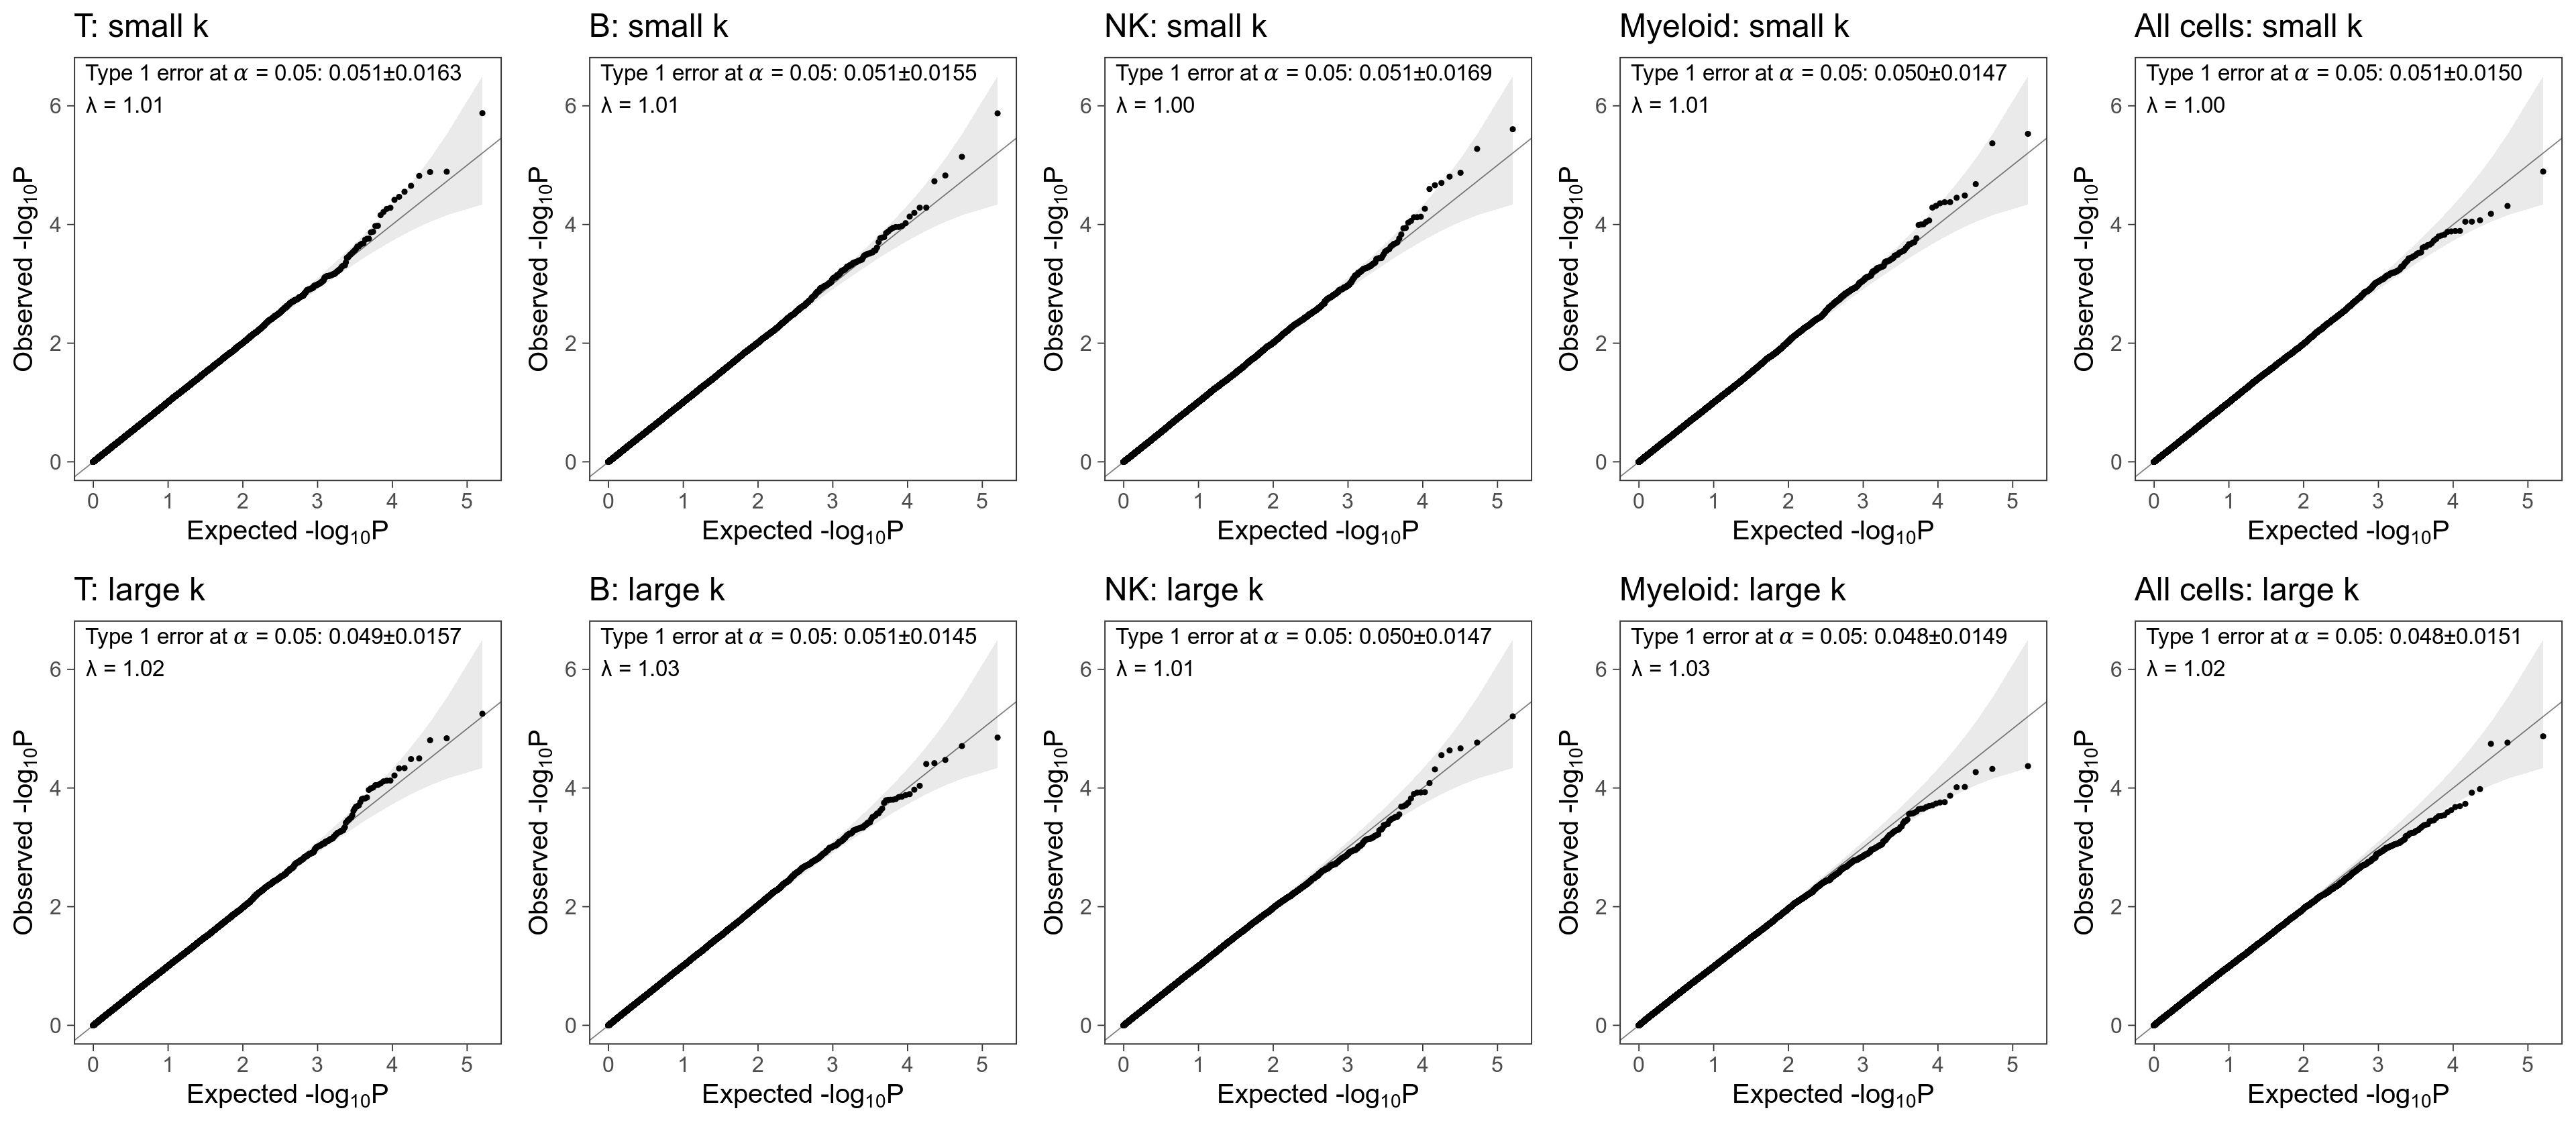

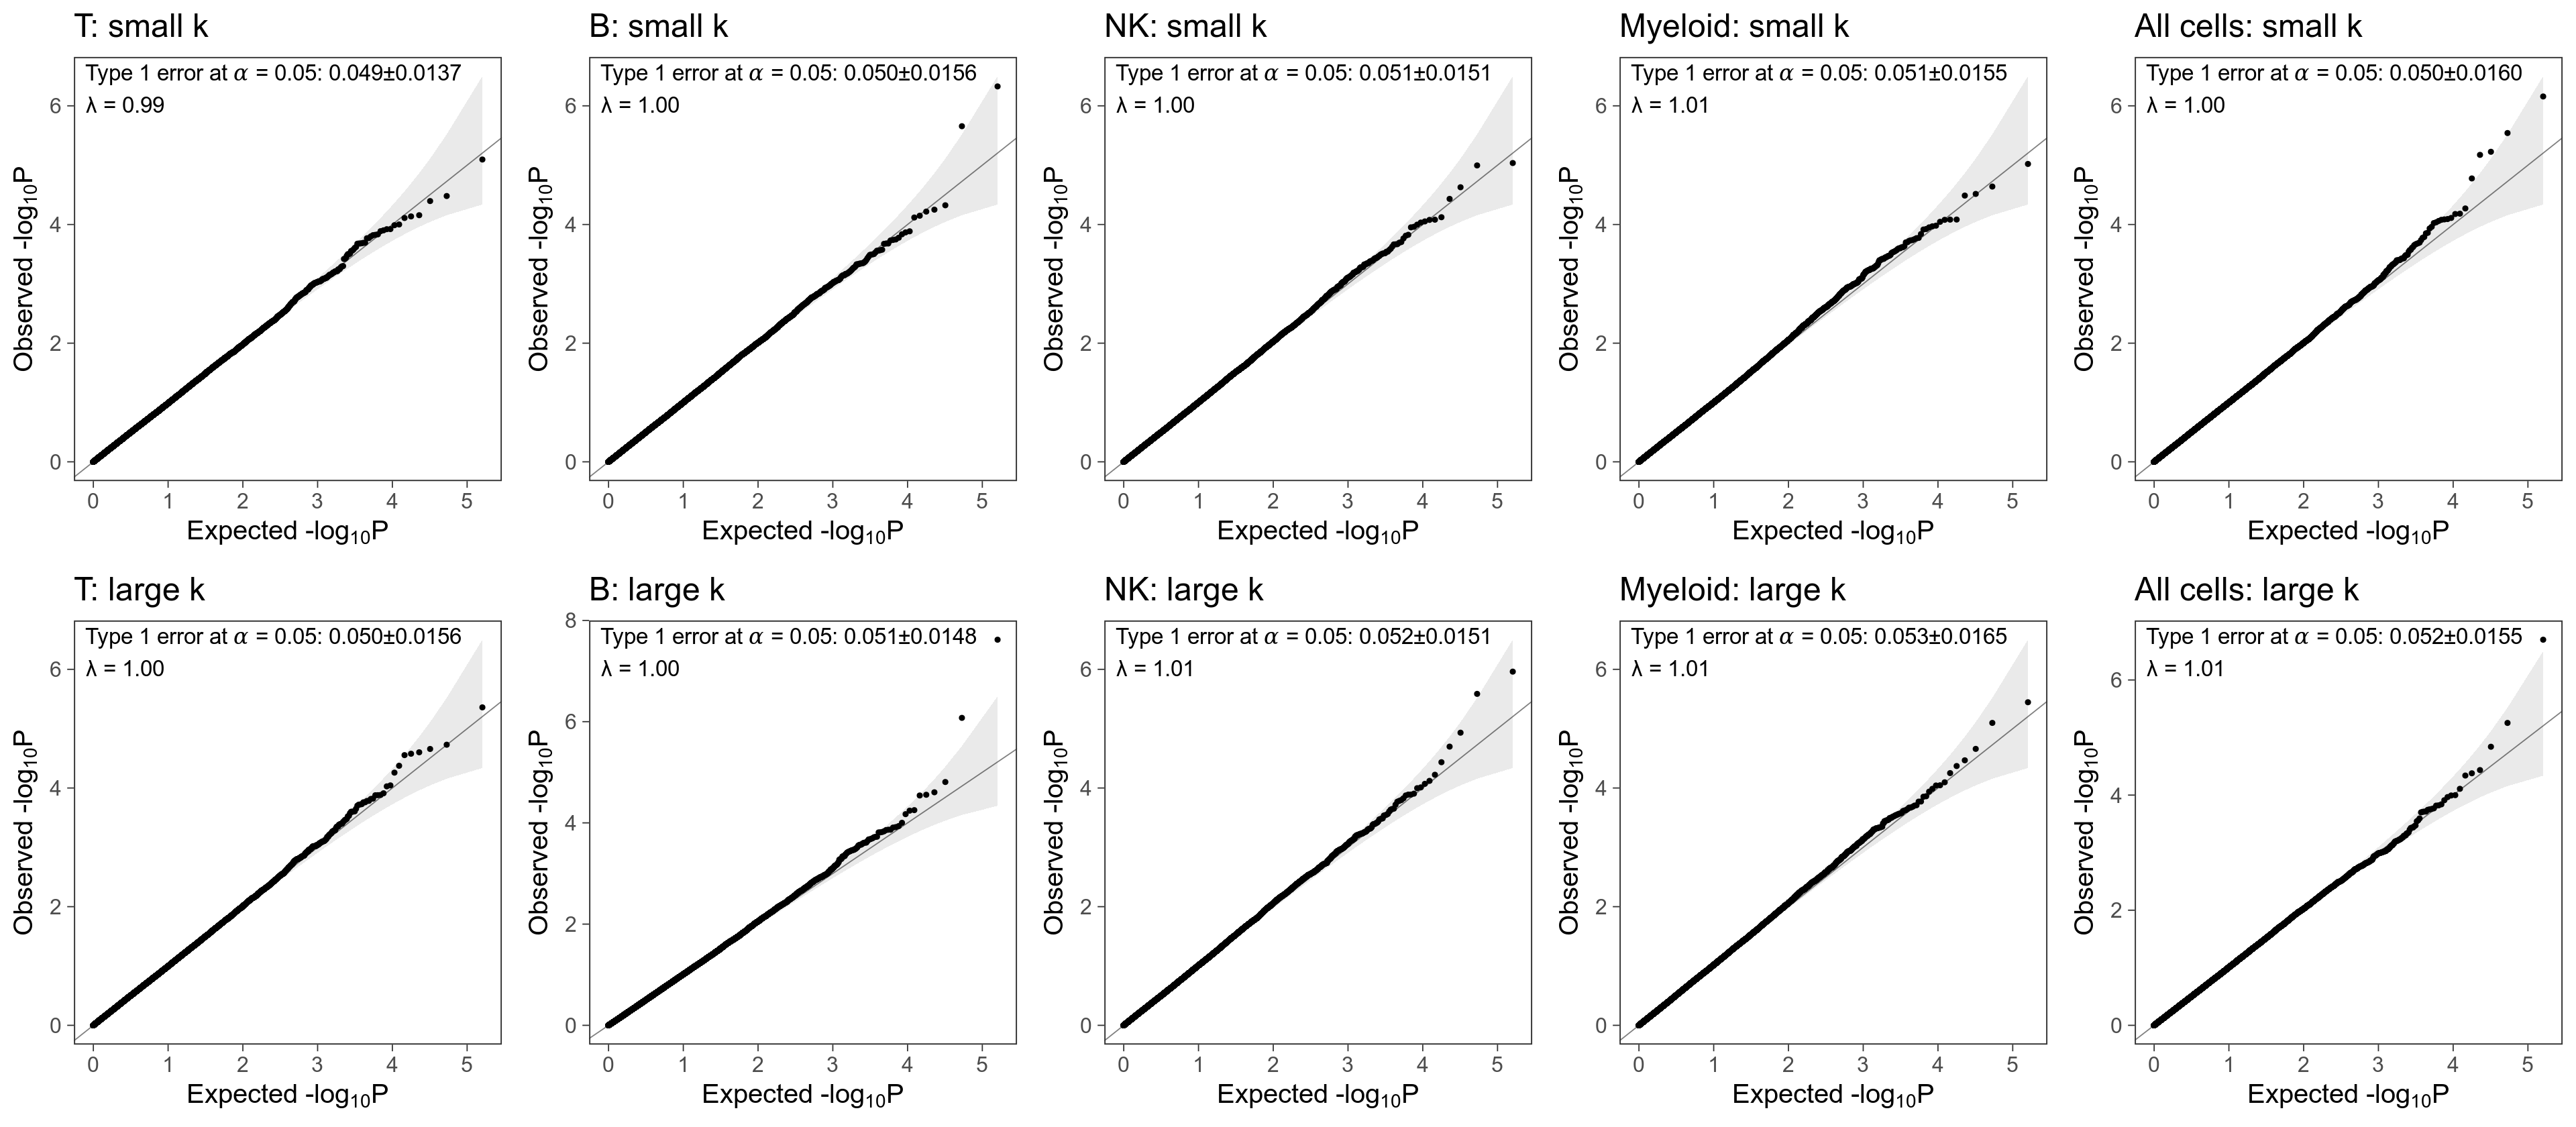

In [8]:
for(maf_string in c("contMAF", "MAF5")){  
    fig_size(32,14)

    celltype="T"
    p1 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/small_k/GeNA_sumstats.txt")), paste0(celltype, ": small k"))

    celltype="B"
    p2 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/small_k/GeNA_sumstats.txt")),  paste0(celltype, ": small k"))

    celltype="NK"
    p3 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/small_k/GeNA_sumstats.txt")),  paste0(celltype, ": small k"))

    celltype="Myeloid"
    p4 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/small_k/GeNA_sumstats.txt")),  paste0(celltype, ": small k"))

    celltype="allcells"
    p5 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/small_k/GeNA_sumstats.txt")), "All cells: small k")
    
        celltype="T"
    p6 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/large_k/GeNA_sumstats.txt")),  paste0(celltype, ": large k"))

    celltype="B"
    p7 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/large_k/GeNA_sumstats.txt")), paste0(celltype, ": large k"))

    celltype="NK"
    p8 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/large_k/GeNA_sumstats.txt")), paste0(celltype, ": large k"))

    celltype="Myeloid"
    p9 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/large_k/GeNA_sumstats.txt")), paste0(celltype, ": large k"))

    celltype="allcells"
    p10 = plot_QQ(c(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,"/",maf_string,
           "/large_k/GeNA_sumstats.txt")), "All cells: large k")

    p11 = grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, nrow = 2)
    ggsave(paste0(fig_dir,"suppfig.QQ_",maf_string,".png"), p11, width = 32, height = 14, dpi = 150)
}

In [9]:
plot_GeNA_ps <-function(maf_string, title, celltypes = c("Myeloid", "B", "T", "NK", "allcells")){
    all_res = data.frame()
    for(i in c(1:length(celltypes))){
        celltype = celltypes[i]
        res = read.delim(paste0("/data/srlab/lrumker/MCSC_Project/cna-qtl/null/results/",celltype,
                  "/",maf_string,"/GeNA_sumstats.txt"), header = TRUE)
        res$ID = apply(as.matrix(res$ID, ncol = 1), 1, get_allele)
        res['nom_sig'] = 1*(res$P<0.05)
        all_res = rbind(all_res, data.frame("nom_sig"= res$nom_sig, "ID"= res$ID, "P"= res$P))
    }
    
    fpr_bysnp = aggregate(all_res[,c("nom_sig")], list(all_res$ID), mean)
    colnames(fpr_bysnp) = c("ID", "FPR")
    
    p_thresh_vec = c(1)
    for(exp_val in seq(0.1,10,0.1)){
        p_thresh_vec = c(p_thresh_vec, 1/(10^exp_val))
    }
    count = c()
    for(p_thresh in p_thresh_vec){
        count = c(count, sum(all_res$P<p_thresh))
    }
    p_thresh_vec = p_thresh_vec[count>0]
    count = count[count>0]

    df = data.frame("p_thresh" = p_thresh_vec, "count" = count)
    df$frac = df$count/dim(all_res)[1]
    return(ggplot(df) +
    geom_point(aes(p_thresh, frac), shape = 20, size = 3) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    scale_x_continuous(trans='log10', limits=c(10^(-5.5), 1)) +
    scale_y_continuous(trans='log10', limits=c(10^(-5.5), 1)) +
    xlab("P-value threshold") +
    ylab("Fraction of observed p-values\nbelow threshold")+
    theme_bw(base_size = 24) + 
    theme(axis.ticks = element_line(size = 0.5), panel.grid = element_blank()) + 
                ggtitle(title)+
        geom_text(x = -Inf, y = Inf, hjust = -0.03, vjust = 1 + 0.15 * 3, 
            label = sprintf("Type 1 error at \U1D6FC = 0.05: %.3f±%.4f", 
                            mean(fpr_bysnp$FPR), sd(fpr_bysnp$FPR)), size = 8, check_overlap=TRUE))
}

Warning message:
“Removed 18 rows containing missing values (geom_point).”


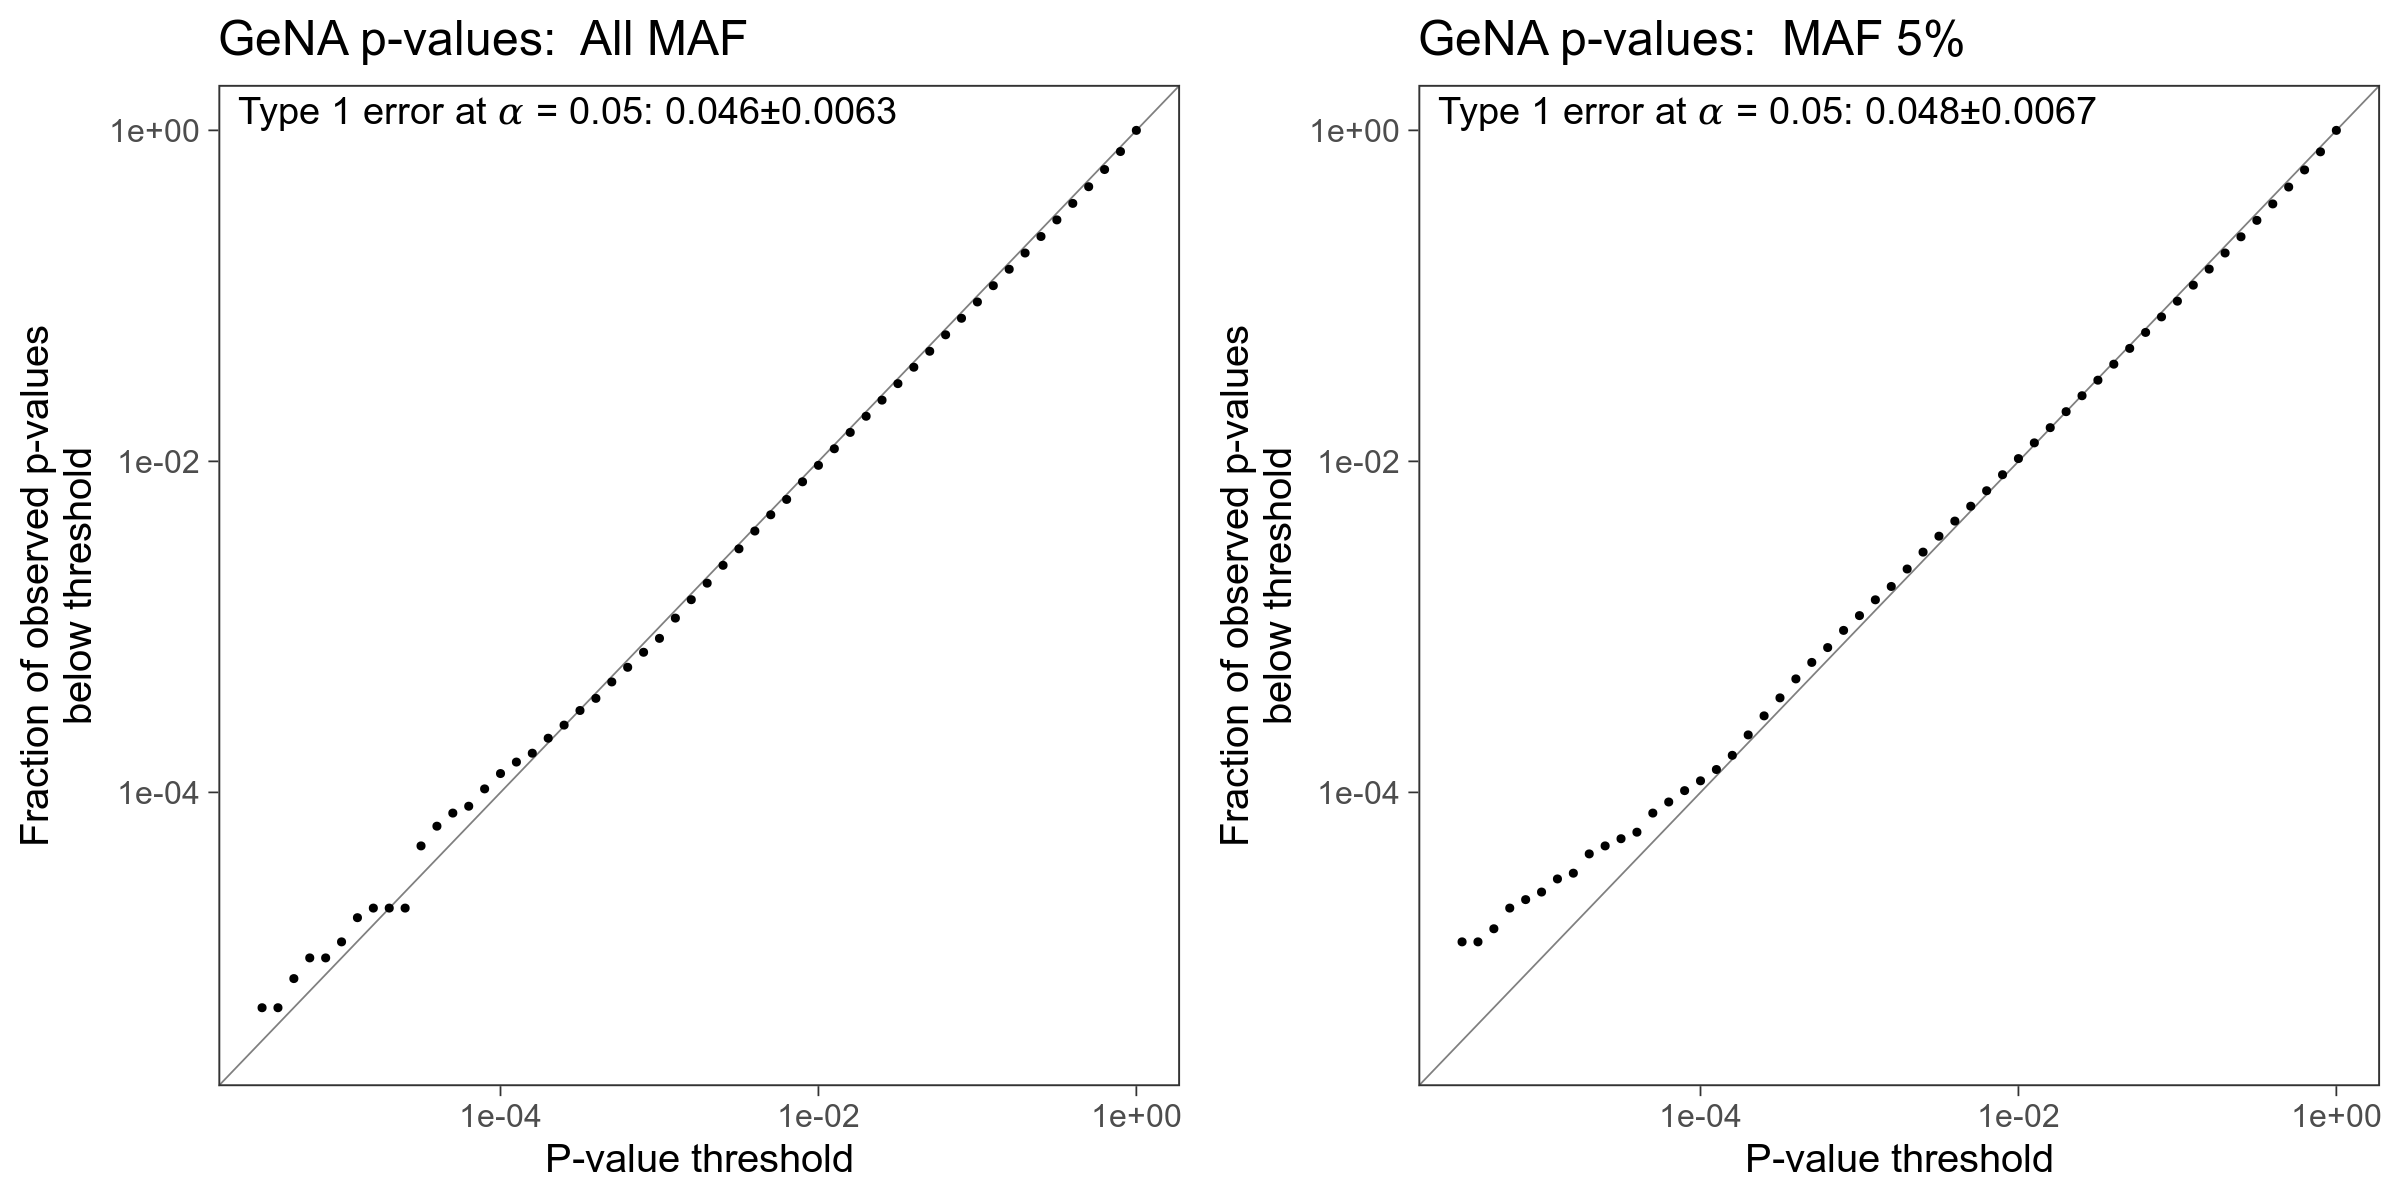

In [10]:
fig_size(20, 10)
p1=plot_GeNA_ps("contMAF", "GeNA p-values:  All MAF")
p2=plot_GeNA_ps("MAF5", "GeNA p-values:  MAF 5%")
p3 = grid.arrange(p1, p2, nrow = 1)
ggsave(paste0(fig_dir,"suppfig.GeNA_ps.png"), p3, width = 20, height = 10, dpi = 250)